In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("model")
sys.path.append("simulation")
from sc_topology_fast import analyze_array_topology_fast
from simulate import simulate_genes

In [4]:
rng = np.random.default_rng(0)

pos_params = [(5.0, 0.14, 5.0, 0.14)] * 10
neg_params = [(5.0, 0.14, 5.0, 0.14)] * 10
rand_params = [(5.0, 0.14)] * 20

X, info = simulate_genes(
    n_cells=50000,
    pos_params=pos_params,
    neg_params=neg_params,
    rand_params=rand_params,
    lambda_pos=+2.569625,   # rho≈+0.3
    lambda_neg=-2.569625,   # rho≈-0.3
    rng=rng
)

print("X shape:", X.shape)


print("corr(pos1):", np.corrcoef(X[:, 0], X[:, 1])[0, 1])
print("corr(neg1):", np.corrcoef(X[:, 20], X[:, 21])[0, 1])
print("corr(rand_last_two):", np.corrcoef(X[:, -1], X[:, -2])[0, 1])

X shape: (50000, 60)
corr(pos1): 0.2990528978680278
corr(neg1): -0.29711819965475533
corr(rand_last_two): -0.0016924014308733015


<Axes: >

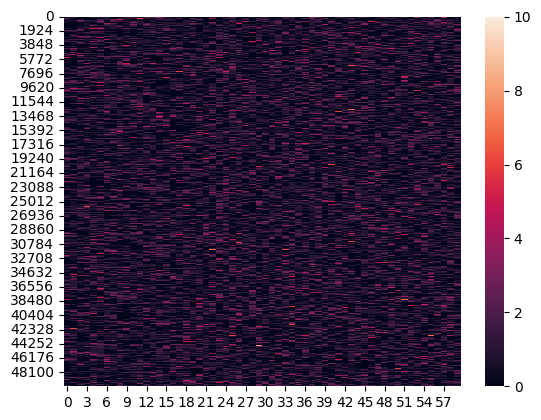

In [5]:
sns.heatmap(X)

In [7]:
marginal_params, lambda_matrix = analyze_array_topology_fast(X, pair_mode='adjacent_pairs')